# Coding Discussion 5

In [1]:
#Set up
import pandas as pd
import numpy as np
import pprint as pp # for printing
import scipy.stats as st # for Normal PDF

# Plotting libraries 
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

# Silence warnings 
import warnings
warnings.filterwarnings("ignore")

## Using Naive Bayesian Classifier¶ 

In [2]:
#Read data
dta = pd.read_csv("~/Desktop/turnout.csv")

In [4]:
# Train-Test split (just using Pandas)
train = dta.sample(frac=.8).reset_index(drop=True)
test = dta.drop(train.index).reset_index(drop=True)

# Print off the split count 
print("Training Data:",train.shape[0],
      "\nTest Data:",test.shape[0])

# Look at the head of the data
train.head()

Training Data: 1600 
Test Data: 400


,id,age,educate,income,vote,white
0,793,64,7.0,1.1277,1,1
1,1938,26,12.0,3.1676,1,0
2,843,61,19.0,6.9491,1,0
3,1097,29,12.0,6.7838,1,1
4,1344,42,12.0,4.0702,1,1


In [6]:
#Calculate Class Probabilities: 𝑃𝑟(𝑐𝑙𝑎𝑠𝑠)

N = train.shape[0]

# Subset the data by class
vote1 = train.query("vote == 1")
vote0 = train.query("vote == 0")

# Calculate the probability for each class
pr_vote_1 = dta1.shape[0]/N
pr_vote_0 = dta0.shape[0]/N

# Print the probabilities
print(
f"""
Pr(vote = 1): {pr_vote_1}
Pr(vote = 0): {pr_vote_0}
""")


Pr(vote = 1): 0.73875
Pr(vote = 0): 0.26125



In [9]:
#Calculate the Conditional Probabilities 𝑃𝑟(𝑑𝑎𝑡𝑎|𝑐𝑙𝑎𝑠𝑠)
#Calculate the number of white individuals who voted and did not voted
#Calculate the number of non-white individuals who votes and did not vote


# Given vote == 1
w1_vote1 = vote1.query("white == 1").shape[0]/vote1.shape[0]
w0_vote1 = vote1.query("white == 0").shape[0]/vote1.shape[0]


# Given Vote == 0
w1_vote0 = vote0.query("white == 1").shape[0]/vote0.shape[0]
w0_vote0 = vote0.query("white == 0").shape[0]/vote0.shape[0]

print(
f"""
Pr(white = 1 |vote = 1): {w1_vote1}
Pr(white = 0 |vote = 1): {w0_vote1}
Pr(white = 1 |vote = 0): {w1_vote0}
Pr(white = 0 |vote = 0): {w0_vote0}
""")


Pr(white = 1 |vote = 1): 0.8747884940778342
Pr(white = 0 |vote = 1): 0.12521150592216582
Pr(white = 1 |vote = 0): 0.7894736842105263
Pr(white = 0 |vote = 0): 0.21052631578947367



In [10]:
#For non-white respondent
prob_vote1 = w0_vote1 * pr_vote_1
prob_vote0 = w0_vote0 * pr_vote_0

print(f"""
Pr(vote = 1) = {prob_vote1}
Pr(vote = 0) = {prob_vote0}
""")


Pr(vote = 1) = 0.0925
Pr(vote = 0) = 0.05499999999999999



.0925  is greater than .055 so we predict a non-white respondent will vote in a presidential election(vote=1).

In [11]:
#For white respondent
prob_vote1 = w1_vote1 * pr_vote_1
prob_vote0 = w1_vote0 * pr_vote_0

print(f"""
Pr(vote = 1) = {prob_vote1}
Pr(vote = 0) = {prob_vote0}
""")


Pr(vote = 1) = 0.64625
Pr(vote = 0) = 0.20625



.0.64625 is greater than .20625 so we predict a white respondent will vote in a presidential election(vote=1).

In [13]:
# Drop columns we don't need 
train1 = train.drop(columns=['id', 'age', 'educate', 'income'])
test1 = test.drop(columns=['id', 'age', 'educate', 'income'])

In [14]:
# calculate the underlying probabilities and then calculate the predictions for each observation in the data
def calc_probs(data,outcome_var=""):
    '''
    Function calculates the class and conditional probabilities in 
    the binary data. 
    
    '''
    # Generate empty dictionary containers.
    class_probs = {};cond_probs = {}
    # Locate all variables that are not the outcome.
    vars = [v for v in data.columns if v != outcome_var]
    # iterate through the class outcomes
    for y, d in data.groupby(outcome_var): 
        # calculate the class probabilities
        class_probs.update({y: d.shape[0]/data.shape[0]})
        for v in vars:
            # calculate the conditional probabilities for each variable given the class.
            pr = d[v].sum()/d.shape[0]
            cond_probs[(v,1,y)] = pr 
            cond_probs[(v,0,y)] = 1 - pr
    return class_probs, cond_probs


# Run
class_probs, cond_probs = calc_probs(train1,outcome_var="vote")

# Print
print("class probabilities",end="\n\n")
pp.pprint(class_probs)
print("\n")
print("conditional probabilities",end="\n\n")
pp.pprint(cond_probs)

class probabilities

{0: 0.26125, 1: 0.73875}


conditional probabilities

{('white', 0, 0): 0.21052631578947367,
 ('white', 0, 1): 0.1252115059221658,
 ('white', 1, 0): 0.7894736842105263,
 ('white', 1, 1): 0.8747884940778342}


In [18]:
#Build a prediction function that combs through the observations in the data and calculates the probabilities and makes a class prediction
def predict(data,class_probs,cond_probs):
    '''
    Function calculates the conditiona probability for membership into each class.
    Then returns both the probabilities and the most likely class. 
    '''
    store_preds = []
    for i,row in data.iterrows():
        pr_1 = 1; pr_0 = 1
        for j in range(1,len(row.index)):
            pr_0 *= cond_probs[(row.index[j],row.values[j],0)]
            pr_1 *= cond_probs[(row.index[j],row.values[j],1)]     
        pr_0 *= class_probs[0]
        pr_1 *= class_probs[1]
        store_preds.append([pr_0,pr_1,max([(pr_0,0),(pr_1,1)])[1]])
    return pd.DataFrame(store_preds,columns=["pr_0","pr_1","pred"])

# Run 
preds = predict(train1, class_probs, cond_probs)
preds.head()

,pr_0,pr_1,pred
0,0.20625,0.64625,1
1,0.05500,0.09250,1
2,0.05500,0.09250,1
3,0.20625,0.64625,1
4,0.20625,0.64625,1


In [19]:
#calculate predictive accuracy
accuracy = sum(train1.vote == preds.pred)/train1.shape[0]
accuracy

0.73875

In [20]:
#Test with the test dataset
test_preds = predict(test1, class_probs, cond_probs)
test_accuracy = sum(test1.vote == test_preds.pred)/test.shape[0]
test_accuracy

0.7

Overall, our model based on race has an out of sample prediction of 70%. The test data was not as accurate as the training data but it is still more accurate than a coin flip.

## Using Naive Bayesian Classifier with Continuous Predictors 

In [49]:
#Drop columns we don't need 
# Drop, rearrange, and rename train df 
train2 = train.drop(columns=['id', 'white', 'age'])
train2 = train2[['vote', 'educate', 'income']]
train2.columns = ['y', 'x1', 'x2']

# Drop, rearrange, and rename test df 
test2 = test.drop(columns=['id', 'white', 'age'])
test2 = test2[['vote', 'educate', 'income']]
test2.columns = ['y', 'x1', 'x2']


In [52]:
#Calculate the class probabilities Pr(class).
y1 = train2.query("y == 1")
y0 = train2.query("y == 0")

# Class probabilities.
pr_y1 = y1.shape[0]/train2.shape[0]
pr_y0 = y0.shape[0]/train2.shape[0]


In [53]:
# Collect the mean and standard dev. of each conditional distribution
dist_locs = \
{("x1",1):{'mean':y1.x2.mean(),'sd':y1.x1.std()},
 ("x1",0):{'mean':y0.x2.mean(),'sd':y0.x1.std()},
 ("x2",1):{'mean':y1.x1.mean(),'sd':y1.x2.std()},
 ("x2",0):{'mean':y0.x1.mean(),'sd':y0.x2.std()}
}

# Print
pp.pprint(dist_locs)

{('x1', 0): {'mean': 2.7889291866028723, 'sd': 3.210028412863581},
 ('x1', 1): {'mean': 4.296558714043997, 'sd': 3.3768621770751674},
 ('x2', 0): {'mean': 10.726076555023923, 'sd': 2.2746903119776736},
 ('x2', 1): {'mean': 12.541878172588833, 'sd': 2.9517148888027886}}


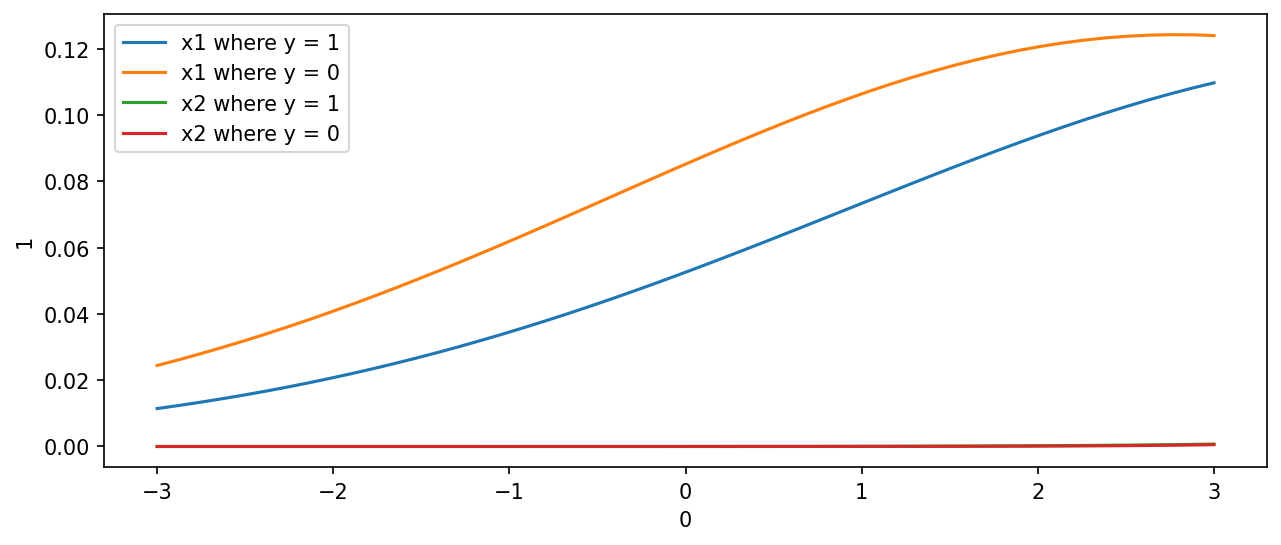

In [54]:
# Plot with seaborn
plt.figure(figsize=(10,4),dpi=150)
for key in dist_locs.keys():
    locs = dist_locs[key]
    d = pd.DataFrame([[i,st.norm(locs['mean'], locs['sd']).pdf(i)] 
                      for i in np.linspace(-3,3)])
    ax = sns.lineplot(d[0],d[1],label=f"{key[0]} where y = {key[1]}")

In [55]:
x1,x2,y = train2.iloc[1,:]
print(y,x1,x2)

3.1676 1.0 12.0


In [56]:
#Prediction for single observation
# Prediction for the 1 class
a = st.norm(dist_locs[("x1",1)]['mean'], dist_locs[("x1",1)]['sd']).pdf(x1)
b = st.norm(dist_locs[("x2",1)]['mean'], dist_locs[("x2",1)]['sd']).pdf(x2)
c = pr_y1
pr_1 = a * b * c 

# Prediction for the 0 class
a = st.norm(dist_locs[("x1",0)]['mean'], dist_locs[("x1",0)]['sd']).pdf(x1)
b = st.norm(dist_locs[("x2",0)]['mean'], dist_locs[("x2",0)]['sd']).pdf(x2)
c = pr_y0
pr_0 = a * b * c 

print(
f'''
    Pr(y == 1| X): {pr_1}
    Pr(y == 0| X): {pr_0}
''')


    Pr(y == 1| X): 0.007202268467504869
    Pr(y == 0| X): 0.00416770260036113



For the single prediction, .007 is greater than .005, so we predict that 𝑦=1.

In [61]:
#Predicting multiple observations
def predict2(data,dist_locs):
    ''''''
    store_preds = []
    for i,row in data.iterrows():
        
        # Get the predictions using a Gaussan distribution
        pr_0 = 1; pr_1 = 1
        for j in range(1,len(row)):
            
            pr_0 *= st.norm(dist_locs[(row.index[j],0)]['mean'],
                            dist_locs[(row.index[j],0)]['sd']).pdf(row.values[j])
            pr_1 *= st.norm(dist_locs[(row.index[j],1)]['mean'], 
                            dist_locs[(row.index[j],1)]['sd']).pdf(row.values[j])
        pr_0 *= pr_y0
        pr_1 *= pr_y1
        
        # Assign the class designation to the highest probability
        if pr_0 >= pr_1:
            class_pred = 0
        else:
            class_pred = 1
            
        store_preds.append([pr_0,pr_1,class_pred])
        
    return pd.DataFrame(store_preds,columns=["pr_0","pr_1","pred"])

# Run
preds_train2 = predict2(train2,dist_locs)

In [62]:
# Predicted output
preds_train2.head(10)

,pr_0,pr_1,pred
0,3.276118e-07,4.846869e-06,1
1,3.714332e-07,5.642794e-06,1
2,4.155955e-09,1.497250e-07,1
3,2.066591e-05,1.304180e-04,1
4,1.283259e-06,1.422174e-05,1
5,9.058633e-08,2.043145e-06,1
6,3.096269e-08,9.823474e-07,1
7,1.842339e-06,1.859531e-05,1
8,1.465009e-08,5.701709e-07,1
9,7.662951e-07,9.953548e-06,1


In [64]:
# Examine the predictive accuracy of the training data.
accuracy_train2 = sum(train2.y == preds_train2.pred)/train2.shape[0]
accuracy_train2

0.73875

In [66]:
# Examine the predictive accuracy on the test data.
preds_test2 = predict2(test2,dist_locs)
accuracy_test2 = sum(test2.y == preds_test2.pred)/test2.shape[0]
accuracy_test2

0.7

Based on age and income, the model predicted whether someone would vote with 70% accuracy. The test data was not as accurate as the training data but it is still more accurate than a coin flip. 